In [1]:
# Common imports
import pandas as pd
import numpy as np
import os

# To plot figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import geopandas
import statsmodels
from statsmodels.stats.proportion import proportions_ztest

In [5]:
file_path='../../cryptic_data_analysis/data_tables/cryptic-analysis-group'

In [6]:
#load files
genomes = pd.read_pickle(file_path+"/GENOMES.pkl.gz")
genomes.reset_index(level=0, inplace=True)
genomes=genomes.loc[(genomes.BELONGS_GPI==True)&(genomes.SITEID!='QC') ]
print('number of isolates =', genomes.UNIQUEID.nunique())

countries = pd.read_csv(file_path+"/COUNTRIES_LOOKUP.csv")
samples = pd.read_pickle(file_path+"/SAMPLES.pkl.gz")
samples.reset_index(level=2, inplace=True)
samples.reset_index(level=1, inplace=True)
samples.reset_index(level=0, inplace=True)
print(samples.COUNTRY_WHERE_SAMPLE_TAKEN.nunique(),'countries in total')
country_list=[]
for i in samples.COUNTRY_WHERE_SAMPLE_TAKEN.unique():
    country_list.append(i)
print(country_list)

phenotypes = pd.read_pickle(file_path+"/UKMYC_PHENOTYPES.pkl.gz")
phenotypes.reset_index(level=1, inplace=True)
phenotypes.reset_index(level=0, inplace=True)
phenotypes=phenotypes.loc[(phenotypes.BELONGS_GPI == True)
                          &(phenotypes.PHENOTYPE_QUALITY.isin(['HIGH','MEDIUM','LOW']))
                          &(phenotypes.DILUTION >=0)
                          &(phenotypes.DRUG!='PAS')
                          &(phenotypes.BINARY_PHENOTYPE.notna())]
phenotypes.loc[((phenotypes['DRUG'] =='INH')&(phenotypes['BINARY_PHENOTYPE']=='I')), 'BINARY_PHENOTYPE'] = 'R'
phenotypes.loc[((phenotypes['DRUG'] =='ETH')&(phenotypes['BINARY_PHENOTYPE']=='I')), 'BINARY_PHENOTYPE'] = 'S'
phenotypes.loc[((phenotypes['DRUG'] =='EMB')&(phenotypes['BINARY_PHENOTYPE']=='I')), 'BINARY_PHENOTYPE'] = 'S'
print('number of isolates with phenotypes to 1+ drugs =',phenotypes.UNIQUEID.nunique())
print('number of MIC readings =',len(phenotypes))

number of isolates = 15211
27 countries in total
['CHN', 'PER', 'VNM', 'GBR', 'SWE', 'BRA', 'ZAF', 'IND', 'TWN', 'AFG', 'NPL', 'DEU', 'TKM', 'KGZ', 'TJK', 'AUS', 'KAZ', 'UKR', 'JPN', 'DZA', 'ITA', 'SOM', 'PAK', 'BFA', 'ALB', 'TUN', 'NGA']
number of isolates with phenotypes to 1+ drugs = 12289
number of MIC readings = 157401


In [55]:
#merge lineage, country and phenotype information
gs = pd.merge(genomes, samples, how='left', on=['SITEID','SUBJID','LABID'])
gps = pd.merge(phenotypes, gs, how='left', on=['UNIQUEID'])
gps.UNIQUEID.nunique()

12289

In [60]:
gps_country=gps.loc[(-gps.COUNTRY_WHERE_SAMPLE_TAKEN.isna())]
gps_country.drop_duplicates('UNIQUEID', inplace = True, keep='first')
gps_country

<ipython-input-60-eafcd490eec3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gps_country.drop_duplicates('UNIQUEID', inplace = True, keep='first')


,UNIQUEID,DRUG,PLATEDESIGN,BELONGS_GPI_x,SITEID_x,DILUTION,PHENOTYPE_QUALITY,READINGDAY,PRIMARY_DILUTION,PRIMARY_METHOD,...,HAIN_FL,HAIN_AM,HAIN_ETH,SMOKER,INJECT_DRUG_USER,IS_HOMELESS,IS_IMPRISONED,HIV,DIABETES,WHO_OUTCOME
0,site.05.subj.PMFR-0743.lab.MFR-247.iso.1,DLM,UKMYC5,True,05,1.0,HIGH,14,1.0,VZ,...,not tested,not tested,not tested,not known,not known,False,False,not known,not known,not known
1,site.10.subj.YA00033005.lab.YA00033005.iso.1,CFZ,UKMYC5,True,10,3.0,HIGH,14,3.0,VZ,...,not tested,not tested,not tested,not known,not known,False,False,not known,not known,not known
5,site.10.subj.YA00048280.lab.YA00048280.iso.1,LZD,UKMYC5,True,10,4.0,HIGH,14,4.0,VZ,...,not tested,not tested,not tested,not known,not known,False,False,not known,not known,not known
6,site.04.subj.00831.lab.717234.iso.1,RIF,UKMYC5,True,04,1.0,LOW,14,1.0,VZ,...,not tested,not tested,not tested,not known,not known,False,False,not known,not known,not known
9,site.03.subj.GB-84450148.lab.IML-01817.iso.1,BDQ,UKMYC6,True,03,4.0,HIGH,14,4.0,VZ,...,not tested,not tested,not tested,not known,not known,False,False,not known,not known,not known
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71723,site.05.subj.LR-2424.lab.FN-00179-14.iso.1,MXF,UKMYC6,True,05,2.0,HIGH,14,2.0,VZ,...,not tested,not tested,not tested,not known,not known,False,False,not known,not known,not known
79406,site.10.subj.YA00134708.lab.YA00134708.iso.1,LEV,UKMYC6,True,10,2.0,HIGH,14,2.0,VZ,...,not tested,not tested,not tested,not known,not known,False,False,not known,not known,not known
81941,site.08.subj.05TB11057.lab.25203.iso.1,AMI,UKMYC5,True,08,1.0,HIGH,14,1.0,VZ,...,not tested,not tested,not tested,not known,"yes, previously",False,False,"tested, positive","tested, not diabetic",died
97419,site.14.subj.1130.lab.1130.iso.1,INH,UKMYC6,True,14,9.0,LOW,14,9.0,VZ,...,not tested,not tested,not tested,not known,not known,False,False,not known,not known,not known


In [62]:

import pandas as pd
import scipy.stats as stats

gps_country=gps.loc[(-gps.COUNTRY_WHERE_SAMPLE_TAKEN.isna())]
gps_country.drop_duplicates('UNIQUEID', inplace = True, keep='first')

# create contingency table
data_crosstab = pd.crosstab(gps_country['COUNTRY_WHERE_SAMPLE_TAKEN'],
                            gps_country['LINEAGE_NAME'],
                           margins=True, margins_name="Total")
print(data_crosstab)

# significance level
alpha = 0.05

# Calcualtion of Chisquare
chi_square = 0
rows = gps_country['COUNTRY_WHERE_SAMPLE_TAKEN'].unique()
columns = gps_country['LINEAGE_NAME'].unique()
for i in columns:
    for j in rows:
        O = data_crosstab[i][j]
        E = data_crosstab[i]['Total'] * data_crosstab['Total'][j] / data_crosstab['Total']['Total']
        chi_square += (O-E)**2/E

# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1))
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
        
print("chisquare-score is:", chi_square, " and p value is:", p_value)
print(conclusion)

LINEAGE_NAME                   Lineage 1  Lineage 2  Lineage 3  Lineage 4  \
COUNTRY_WHERE_SAMPLE_TAKEN                                                  
ALB                         0          0          0          0          7   
BFA                         0          3          1          8         65   
BRA                         0          1          8          0        333   
CHN                         0          2        716         16        373   
DEU                         1         19         84         46        293   
DZA                         0          0          0          0         24   
IND                         4        257        565        407        235   
ITA                         1          6         75         12        243   
JPN                         0          0          0          0          1   
KGZ                         0          0         25          0          3   
NGA                         0          0          0          0         15   

<ipython-input-62-c3774732a5ba>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gps_country.drop_duplicates('UNIQUEID', inplace = True, keep='first')


In [8]:
gps.LINEAGE_NAME.unique()

['Lineage 4', 'Lineage 1', 'Lineage 2', 'Lineage 3', '', 'Lineage 6']
Categories (6, object): ['Lineage 4', 'Lineage 1', 'Lineage 2', 'Lineage 3', '', 'Lineage 6']

In [30]:
gps.loc[gps.COUNTRY_WHERE_SAMPLE_TAKEN.isna()]

,UNIQUEID,DRUG,PLATEDESIGN,BELONGS_GPI_x,SITEID_x,DILUTION,PHENOTYPE_QUALITY,READINGDAY,PRIMARY_DILUTION,PRIMARY_METHOD,...,HAIN_FL,HAIN_AM,HAIN_ETH,SMOKER,INJECT_DRUG_USER,IS_HOMELESS,IS_IMPRISONED,HIV,DIABETES,WHO_OUTCOME
2,site.06.subj.06TB_1032.lab.06MIL2037.iso.1,MXF,UKMYC6,True,06,3.0,HIGH,14,3.0,VZ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,site.11.subj.XTB_17-147.lab.XTB_17-147.iso.1,BDQ,UKMYC6,True,11,3.0,MEDIUM,14,3.0,VZ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,site.06.subj.06TB_0404.lab.06MIL1373.iso.1,MXF,UKMYC6,True,06,3.0,HIGH,21,3.0,VZ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,site.06.subj.06TB_0876.lab.06MIL1871.iso.1,CFZ,UKMYC6,True,06,3.0,MEDIUM,14,3.0,VZ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,site.11.subj.XTB_18-014.lab.XTB_18-014.iso.1,LZD,UKMYC6,True,11,4.0,MEDIUM,14,4.0,VZ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157384,site.06.subj.DJB12.lab.06MIL1513.iso.1,EMB,UKMYC6,True,06,5.0,HIGH,21,5.0,VZ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
157387,site.08.subj.02TB0270.lab.17432.iso.1,RFB,UKMYC6,True,08,1.0,HIGH,14,1.0,VZ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
157392,site.06.subj.A43647.lab.06MIL1947.iso.1,ETH,UKMYC6,True,06,3.0,LOW,14,3.0,VZ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
157396,site.03.subj.T2447.lab.IML-00043.iso.1,RFB,UKMYC6,True,03,1.0,HIGH,14,1.0,VZ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
colors=['#ffffd9','#97d6b9','#1f80b8','#081d58']

l1_list=[]
l2_list=[]
l3_list=[]
l4_list=[]
l6_list=[]
other_list=[]

countries=gps.COUNTRY_WHERE_SAMPLE_TAKEN.dropna().unique().to_list()


for ii in countries:
    u_df=gps.loc[(gps.COUNTRY_WHERE_SAMPLE_TAKEN==ii)]
    l1_list.append(u_df.loc[u_df.LINEAGE_NAME=='Lineage 1'].UNIQUEID.nunique())
    l2_list.append(u_df.loc[u_df.LINEAGE_NAME=='Lineage 2'].UNIQUEID.nunique())
    l3_list.append(u_df.loc[u_df.LINEAGE_NAME=='Lineage 3'].UNIQUEID.nunique())
    l4_list.append(u_df.loc[u_df.LINEAGE_NAME=='Lineage 4'].UNIQUEID.nunique())
    l6_list.append(u_df.loc[u_df.LINEAGE_NAME=='Lineage 6'].UNIQUEID.nunique())
    other_list.append(u_df.loc[u_df.LINEAGE_NAME==''].UNIQUEID.nunique())

nan_df=gps.loc[(gps.COUNTRY_WHERE_SAMPLE_TAKEN.isna())]
l1_list.append(nan_df.loc[nan_df.LINEAGE_NAME=='Lineage 1'].UNIQUEID.nunique())
l2_list.append(nan_df.loc[nan_df.LINEAGE_NAME=='Lineage 2'].UNIQUEID.nunique())
l3_list.append(nan_df.loc[nan_df.LINEAGE_NAME=='Lineage 3'].UNIQUEID.nunique())
l4_list.append(nan_df.loc[nan_df.LINEAGE_NAME=='Lineage 4'].UNIQUEID.nunique())
l6_list.append(nan_df.loc[nan_df.LINEAGE_NAME=='Lineage 6'].UNIQUEID.nunique())
other_list.append(nan_df.loc[nan_df.LINEAGE_NAME==''].UNIQUEID.nunique())
countries.append('UNKNOWN')
            
lc_summary=pd.DataFrame(list(zip(countries, l1_list, l2_list, l3_list, l4_list, l6_list, other_list)),
               columns =['COUNTRY','L1', 'L2', 'L3', 'L4','L6','other'])
lc_summary['TOTAL']=lc_summary['L1']+lc_summary['L2']+lc_summary['L3']+lc_summary['L4']+lc_summary['L6']+lc_summary['other']
lc_summary

,COUNTRY,L1,L2,L3,L4,L6,other,TOTAL
0,PER,1,339,0,2297,0,1,2638
1,ZAF,57,658,40,885,0,1,1641
2,IND,257,565,407,235,0,4,1468
3,DEU,19,84,46,293,1,1,444
4,ITA,6,75,12,243,0,1,337
5,VNM,219,614,3,99,0,0,935
6,CHN,2,716,16,373,0,0,1107
7,PAK,29,23,360,77,0,0,489
8,TJK,0,15,0,4,0,0,19
9,TKM,0,85,1,32,0,0,118


In [34]:


world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")]
tb_world=pd.merge(world, lc_summary, left_on='iso_a3', right_on='COUNTRY', how='left')

tb_world_pies=tb_world.loc[(tb_world['TOTAL']>=0)]
tb_world_pies=pd.merge(tb_world_pies,countries, how='left', left_on='COUNTRY', right_on='COUNTRY_CODE_3_LETTER')




lat=tb_world_pies.LAT
long=tb_world_pies.LONG
#pick out R categories for pie charts
r1=tb_world_pies.L1
r2=tb_world_pies.L2
r3=tb_world_pies.L3
r4=tb_world_pies.L4
r5=tb_world_pies.L6
r6=tb_world_pies.other


u1=lc_summary.loc[lc_summary.COUNTRY=='UNKNOWN'].L1.to_list()[0]
u2=lc_summary.loc[lc_summary.COUNTRY=='UNKNOWN'].L2.to_list()[0]
u3=lc_summary.loc[lc_summary.COUNTRY=='UNKNOWN'].L3.to_list()[0]
u4=lc_summary.loc[lc_summary.COUNTRY=='UNKNOWN'].L4.to_list()[0]
u5=lc_summary.loc[lc_summary.COUNTRY=='UNKNOWN'].L6.to_list()[0]
u6=lc_summary.loc[lc_summary.COUNTRY=='UNKNOWN'].other.to_list()[0]

t1=lc_summary.L1.sum()
t2=lc_summary.L2.sum()
t3=lc_summary.L3.sum()
t4=lc_summary.L4.sum()
t5=lc_summary.L6.sum()
t6=lc_summary.other.sum()

In [35]:
tb_world_pies

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,COUNTRY,L1,L2,L3,L4,L6,other,TOTAL,COUNTRY_NAME,COUNTRY_CODE_2_LETTER,COUNTRY_CODE_3_LETTER,COUNTRY_CODE_NUMERIC,LAT,LONG
0,54841552,Africa,South Africa,ZAF,739100.0,"POLYGON ((16.34498 -28.57671, 16.82402 -28.082...",ZAF,57.0,658.0,40.0,885.0,0.0,1.0,1641.0,South Africa,ZA,ZAF,710,-29.0000,24.0000
1,207353391,South America,Brazil,BRA,3081000.0,"POLYGON ((-53.37366 -33.76838, -53.65054 -33.2...",BRA,1.0,8.0,0.0,333.0,0.0,0.0,342.0,Brazil,BR,BRA,76,-10.0000,-55.0000
2,31036656,South America,Peru,PER,410400.0,"POLYGON ((-69.89364 -4.29819, -70.79477 -4.251...",PER,1.0,339.0,0.0,2297.0,0.0,1.0,2638.0,Peru,PE,PER,604,-10.0000,-76.0000
3,190632261,Africa,Nigeria,NGA,1089000.0,"POLYGON ((2.69170 6.25882, 2.74906 7.87073, 2....",NGA,0.0,0.0,0.0,15.0,0.0,0.0,15.0,Nigeria,NG,NGA,566,10.0000,8.0000
4,20107509,Africa,Burkina Faso,BFA,32990.0,"POLYGON ((-5.40434 10.37074, -5.47056 10.95127...",BFA,3.0,1.0,8.0,65.0,1.0,0.0,78.0,Burkina Faso,BF,BFA,854,13.0000,-2.0000
5,11403800,Africa,Tunisia,TUN,130800.0,"POLYGON ((9.48214 30.30756, 9.05560 32.10269, ...",TUN,0.0,0.0,0.0,2.0,0.0,0.0,2.0,Tunisia,TN,TUN,788,34.0000,9.0000
6,40969443,Africa,Algeria,DZA,609400.0,"POLYGON ((-8.68440 27.39574, -8.66512 27.58948...",DZA,0.0,0.0,0.0,24.0,0.0,0.0,24.0,Algeria,DZ,DZA,12,28.0000,3.0000
7,96160163,Asia,Vietnam,VNM,594900.0,"POLYGON ((104.33433 10.48654, 105.19991 10.889...",VNM,219.0,614.0,3.0,99.0,0.0,0.0,935.0,Vietnam,VN,VNM,704,16.0000,106.0000
8,1281935911,Asia,India,IND,8721000.0,"POLYGON ((97.32711 28.26158, 97.40256 27.88254...",IND,257.0,565.0,407.0,235.0,0.0,4.0,1468.0,India,IN,IND,356,20.0000,77.0000
9,29384297,Asia,Nepal,NPL,71520.0,"POLYGON ((88.12044 27.87654, 88.04313 27.44582...",NPL,5.0,137.0,34.0,21.0,0.0,0.0,197.0,Nepal,NP,NPL,524,28.0000,84.0000


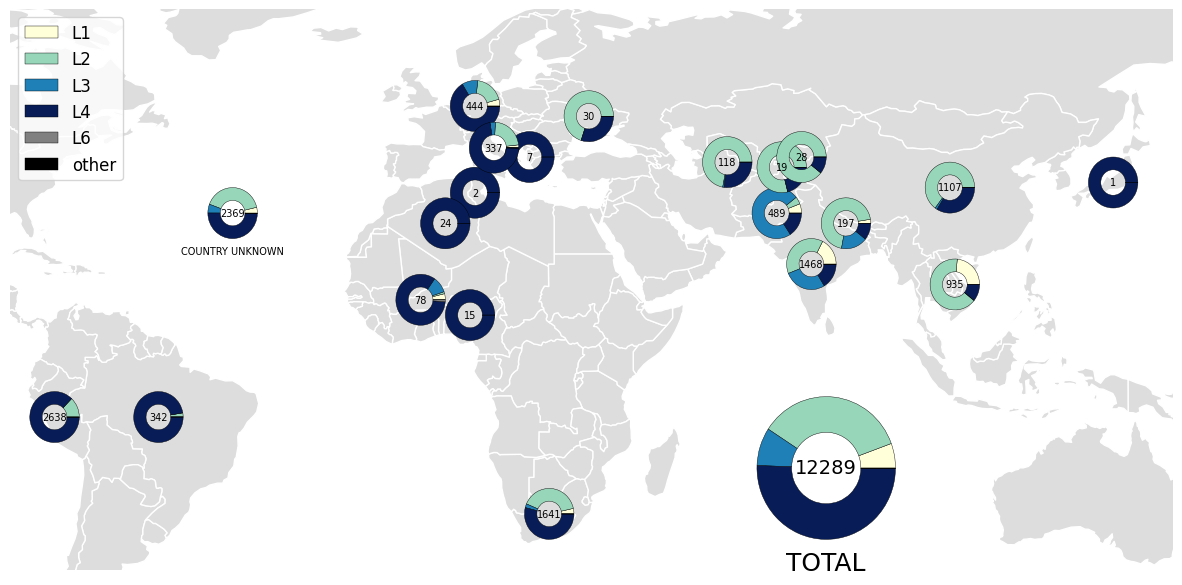

In [46]:


#make graph
fig, ax = plt.subplots(1, 1,figsize=(15,8))
for i in range(len(tb_world_pies)):
    center=(long[i],lat[i])
    patches, texts=ax.pie([r1[i],r2[i],r3[i], r4[i], r5[i], r6[i]],radius=5,
                   colors=['#ffffd9','#97d6b9','#1f80b8','#081d58', 'gray', 'k'], 
                          center=center)
    plt.setp( patches, width=2.5, edgecolor='k', linewidth=0.3)
    ax.legend(patches,['L1','L2','L3','L4','L6','other'], fontsize=12,loc='upper left')
    plt.text(long[i],lat[i], tb_world_pies.TOTAL.astype('int64').to_list()[i], ha='center', va='center', size=7)


center=(-40,30)
patches, texts=ax.pie([u1,u2,u3,u4,u5,u6],radius=5,
                   colors=['#ffffd9','#97d6b9','#1f80b8','#081d58', 'gray', 'k'], 
                          center=center)
plt.setp( patches, width=2.5, edgecolor='k', linewidth=0.3)
plt.text(-40,22, 'COUNTRY UNKNOWN', ha='center', size=7)
plt.text(-40,30, lc_summary.loc[lc_summary.COUNTRY=='UNKNOWN'].TOTAL.astype('int64').to_list()[0], ha='center', va='center', size=7)

center=(80,-20)
patches, texts=ax.pie([t1,t2,t3,t4,t5,t6],radius=14,
                   colors=['#ffffd9','#97d6b9','#1f80b8','#081d58', 'gray', 'k'], 
                          center=center, textprops={'va':'center','ha':'center','size':8}) 
                      #labels=[str(t1),str(t2),str(t3),str(t4),str(t5),str(t6)], labeldistance=1.2)

plt.setp( patches, width=7, edgecolor='k', linewidth=0.3)
plt.text(80,-40, 'TOTAL', ha='center', size=18)
plt.text(80,-20, int(lc_summary.TOTAL.sum()), ha='center', va='center', size=14)


background=world.plot(ax=ax, color='#dddddd', edgecolor='w')
#wp=tb_world.loc[tb_world.COUNTRY!='UNKNOWN'].plot(ax=ax,edgecolor='w',
 #                figsize=(10, 10),
  #               color='grey')

ax.set_xlim(-85,150)
ax.set_ylim(-40,70)


plt.savefig('lin_map_fig.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

In [48]:
lc_summary

,COUNTRY,L1,L2,L3,L4,L6,other,TOTAL
0,PER,1,339,0,2297,0,1,2638
1,ZAF,57,658,40,885,0,1,1641
2,IND,257,565,407,235,0,4,1468
3,DEU,19,84,46,293,1,1,444
4,ITA,6,75,12,243,0,1,337
5,VNM,219,614,3,99,0,0,935
6,CHN,2,716,16,373,0,0,1107
7,PAK,29,23,360,77,0,0,489
8,TJK,0,15,0,4,0,0,19
9,TKM,0,85,1,32,0,0,118


In [52]:
for i in [t1,t2,t3,t4,t5,t6]:print(i, i/12289*100)

686 5.582228008788348
4330 35.234762795996424
1059 8.617462771584345
6194 50.40279925136301
6 0.04882415168036455
14 0.1139230205875173
